# Building a U-Net CNN Model for Magnetic Resonance Imaging (MRI) Segmentation

This tutorial will walk through building and training a U-Net convolutional neural network (CNN) model for 2D image segmentation of MRI data from scratch. We'll use the [SPIDER](https://huggingface.co/datasets/cdoswald/SPIDER) dataset containing 447 lumbar spine sagittal MRI scans for 218 unique patients.


## What is U-Net?

U-Net was first introduced in a 2015 paper titled "[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)" by Olaf Ronneberger, Philipp Fischer, and Thomas Brox, at the University of Freiburg, Germany. Their paper develops both a model architecture (U-Net) and a training strategy (data augmentation and a weighted loss) that enables more precise image segmentation with relatively few training examples.


The original model architecture looks like this:

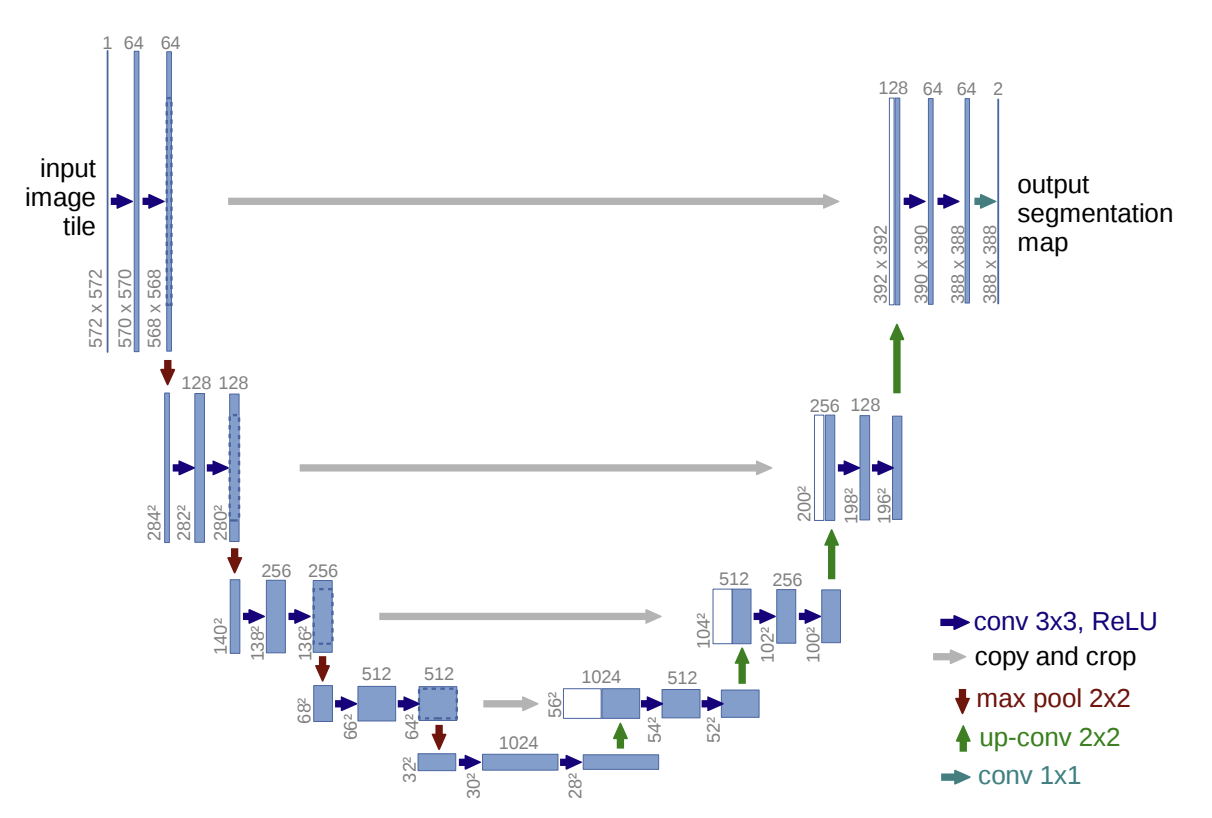

The model has a "contracting network", which encodes higher-dimensional feature information as it reduces the spatial information, and an expanding network, which upsamples the spatial information to restore the original image size while also propagating the feature information to higher resolution layers. It also includes skip connections from the contracting to the expanding network. The model consists solely of 2D convolutional layers, ReLU activation functions, 2x2 max pooling layers, and 2x2 upsampling (tranposed convolutional) layers.

## Downloading the SPIDER Dataset

First, we'll install the required dependencies and download the SPIDER dataset from HuggingFace:

In [1]:
# Create directories
from google.colab import drive
drive.mount('/content/drive')

import os
models_dir = '/content/drive/MyDrive/Colab Notebooks/Models'
os.makedirs(models_dir, exist_ok=True)

Mounted at /content/drive


In [2]:
!pip install datasets -q
!pip install scikit-image -q
!pip install SimpleITK -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 31.7 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset

dataset = load_dataset(
    "cdoswald/SPIDER",
    name="default", # Default configuration loads all 447 examples
    trust_remote_code=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

We'll check the structure of the data to confirm that we have a train, validation, and test split:

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'scan_type', 'image', 'mask', 'image_path', 'mask_path', 'metadata', 'rad_gradings'],
        num_rows: 304
    })
    validation: Dataset({
        features: ['patient_id', 'scan_type', 'image', 'mask', 'image_path', 'mask_path', 'metadata', 'rad_gradings'],
        num_rows: 75
    })
    test: Dataset({
        features: ['patient_id', 'scan_type', 'image', 'mask', 'image_path', 'mask_path', 'metadata', 'rad_gradings'],
        num_rows: 68
    })
})

## Defining the Model Architecture



Next, let's specify the model architecture. This example uses [PyTorch](https://pytorch.org/tutorials/beginner/basics/intro.html), but you could build something similar with [Keras/TensorFlow](https://keras.io/getting_started/).

We'll start by importing packages and checking if we have a GPU available for model training:

In [5]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


We'll then create an `EncodeBlock` class that will encode higher-dimensional feature information at each successive level of the model. The `EncodeBlock` uses two convolutional layers with a 3x3 kernel and padding to maintain the input image size after each convolution layer. The spatial information is downsampled using a 2x2 max pooling layer prior to the second, third, fourth, and fifth encoding blocks (see image of model architecture above).

In [7]:
class EncodeBlock(nn.Module):
    """Apply 2 successive layers of 3x3 convolutions and ReLU activation."""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x, maxpool_first=False):
        if maxpool_first:
            x = F.max_pool2d(x, kernel_size=2, stride=2)
        return self.encode(x)


We'll also create a `DecodeBlock` class. This class will restore the original image dimensions (e.g., 512x512) through 2x2 [transpose convolution](https://www.cs.toronto.edu/~lczhang/321/lec/autoencoder_notes.html) layers, upsampling the spatial dimension. At each level, the upsampled higher-dimensional features will be concatenated with high resolution features from the corresponding encoding block, essentially allowing that information to skip subsequent encoding and decoding operations. Note that this concatenation operation requires that the shape of the outputs from the encoding block match the shape of the outputs from the upsampling operation in the decoding block (so we pad the upsampled outputs). Additionally, at each upsampling operation, we halve the number of feature dimensions for our decoded output prior to concatenating with the encoded output.

In [8]:
class DecodeBlock(nn.Module):
    """Upsample using 2x2 transposed convolution layers, concatenate with skip
    connections, and then apply 2 successive layers of 3x3 convolutions and ReLU."""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(
            in_channels,
            in_channels // 2,
            kernel_size=2,
            stride=2,
        )
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x, skip):
        x = self.upsample(x)
        # Crop skip tensor (based on
        # https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py)
        height_diff = skip.size()[2] - x.size()[2]
        width_diff = skip.size()[3] - x.size()[3]
        pad = [
            width_diff // 2, width_diff - width_diff // 2, # Pad last dimension
            height_diff // 2, height_diff - height_diff // 2, # Pad second-to-last dimension
        ]
        x = F.pad(x, pad)
        x = torch.cat([x, skip], dim=1)
        return self.decode(x)


Finally, we'll put all of the encoder and decoder blocks together into the U-shaped architecture:

In [9]:
class SimpleUNet(nn.Module):
    """Basic U-Net model architecture."""

    def __init__(self, in_channels, n_classes):
        super().__init__()

        # Create encoder (channel dimensions based on original U-Net paper)
        self.encode_1 = EncodeBlock(in_channels, 64)
        self.encode_2 = EncodeBlock(64, 128)
        self.encode_3 = EncodeBlock(128, 256)
        self.encode_4 = EncodeBlock(256, 512)

        self.encode_last = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Create decoder
        self.decode_1 = DecodeBlock(1024, 512)
        self.decode_2 = DecodeBlock(512, 256)
        self.decode_3 = DecodeBlock(256, 128)
        self.decode_4 = DecodeBlock(128, 64)

        # Original paper used a 1x1 convolution to map features to n_classes
        self.decode_last = nn.Conv2d(64, n_classes, kernel_size=1) #1x1 Conv2d


    def forward(self, x):
        # Encoding
        x1 = self.encode_1(x)
        x2 = self.encode_2(x1, maxpool_first=True)
        x3 = self.encode_3(x2, maxpool_first=True)
        x4 = self.encode_4(x3, maxpool_first=True)
        x = self.encode_last(x4)
        # Decoding
        x = self.decode_1(x, skip=x4)
        x = self.decode_2(x, skip=x3)
        x = self.decode_3(x, skip=x2)
        x = self.decode_4(x, skip=x1)
        outputs = self.decode_last(x)
        return outputs


## Training the Model

To simplify the segmentation task for this tutorial, we'll use our model to segment only vertebrae vs. non-vertebrae pixels (as opposed to all of the types of anatomical structures that were segmented in the original SPIDER data). We'll use the momentum of 0.99 and batch size of 1 image used in the original paper. We'll also frame our problem as a multi-class classification problem and set our loss function as Cross Entropy (see this [helpful post](https://discuss.pytorch.org/t/understanding-channels-in-binary-segmentation/79966/2) for more details).

In [10]:
# Set parameters from U-Net paper
momentum = 0.99
batch_size = 1

# Set task-specific parameters
in_channels = 1     # grayscale images
n_classes = 2       # vertebrae/non-vertebrae

# Create model
model = SimpleUNet(in_channels, n_classes)
model.to(device)

# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(momentum, 0.999))

# Specify loss function
criterion = nn.CrossEntropyLoss()

Next we need to modify our segmentation masks so that they contain only 0's and 1's. We'll define a function to do that:

In [11]:
def convert_mask_to_binary(mask: torch.tensor, lower: int, upper: int) -> torch.tensor:
    """Convert segmentation mask from [0, 225] to [0, 1].
    Lower and upper indicate the range of values that will be mapped
    to the value 1 (e.g., for vertebrae, lower=1 and upper=7). See
    SPIDER documentation for more details.
    """
    return torch.where((mask < lower) | (mask > upper), 0, 1)

Now we can start training. We'll loop over the `train` split of the SPIDER dataset loaded from HuggingFace and extract the `image` and `mask` objects. These objects are sequences of 2-dimensional grayscale images/masks, where the length of the sequence indicates the depth (since we're ultimately dealing with 3-dimensional volumetric data). For this tutorial, we'll take a single image and mask from each sequence (i.e., depth = 5) and reshape the image to (batch_size, channels, height, and width) and mask to (batch_size, height, width), since these are the order of the dimensions expected by our model. After iterating through all 304 training examples and recording the training loss, we'll calculate the validation loss for all 75 validation examples. If the loss decreases from our best loss to-date, then we'll save out the model parameters to use for inference later.

In [ ]:
n_epochs = 40
depth_idx = 4
lowest_loss = None

for epoch in range(n_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    # Training loop
    model.train()
    for batch_idx, train_data in enumerate(dataset['train']):

        # Extract training image and mask (single slice from "depth" dim)
        train_image = torch.tensor(
            np.array(train_data['image'][depth_idx], dtype=np.int32)
        ).squeeze().float()
        train_mask = torch.tensor(
            np.array(train_data['mask'][depth_idx], dtype=np.int16)
        ).squeeze()

        # Convert mask to binary (vertebrae/non-vertebrae)
        train_mask = convert_mask_to_binary(train_mask, 1, 7).reshape(512, 512)

        # Convert input image to (batch_size, channels, height, width)
        train_image = train_image[None, None, :, :].to(device)

        # Convert mask to (batch_size, height, width)
        train_mask = train_mask[None, :, :].to(device)

        # Forward pass
        output = model(train_image)

        # Backward pass
        optimizer.zero_grad()
        loss = criterion(output, train_mask)
        loss.backward()
        optimizer.step()

        # Record batch loss
        epoch_train_loss += loss.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for batch_idx, val_data in enumerate(dataset['validation']):

            # Extract validation image and mask (single slice from "depth" dim)
            val_image = torch.tensor(
                np.array(val_data['image'][depth_idx], dtype=np.int32)
            ).squeeze().float()
            val_mask = torch.tensor(
                np.array(val_data['mask'][depth_idx], dtype=np.int16)
            ).squeeze()

            # Convert mask to binary (vertebrae/non-vertebrae)
            val_mask = convert_mask_to_binary(val_mask, 1, 7)

            # Convert input image to (batch_size, channels, height, width)
            val_image = val_image[None, None, :, :].to(device)

            # Convert mask to (batch_size, height, width)
            val_mask = val_mask[None, :, :].to(device)

            # Generate prediction
            output = model(val_image)

            # Compute loss
            loss = criterion(output, val_mask)

            # Record batch loss
            epoch_val_loss += loss.item()

    # Print loss
    print(f'Epoch {epoch+1} validation loss: {round(epoch_val_loss, 3)}')

    # Save model if improving
    if (lowest_loss is None) or (epoch_val_loss < lowest_loss):
        lowest_loss = epoch_val_loss
        save_model_path = os.path.join(models_dir, f'UNet_SPIDER_epoch{epoch+1}.pt')
        torch.save(model.state_dict(), save_model_path)
        print(f'Model saved for epoch {epoch+1}.')


Epoch 1 validation loss: 13.031
Model saved for epoch 1.
Epoch 2 validation loss: 6.949
Model saved for epoch 2.
Epoch 3 validation loss: 6.768
Model saved for epoch 3.
Epoch 4 validation loss: 5.268
Model saved for epoch 4.
Epoch 5 validation loss: 4.726
Model saved for epoch 5.


## Generating New Segmentation Masks for the Test Data

Let's evaluate our model qualitatively by predicting new masks for the held-out test images. First, we'll load the saved model parameters from the model directory:

In [33]:
load_model_path = os.path.join(models_dir, 'UNet_SPIDER_v2_epoch35.pt')
model.load_state_dict(torch.load(load_model_path, map_location=torch.device(device)))

<All keys matched successfully>

We'll create a function called `predict` that takes an element from our SPIDER test dataset and returns the predicted mask, original image, and actual mask:

In [34]:
def predict(model, test_data, depth_idx):
    """Generate prediction for a single test image."""
    model.eval()
    with torch.no_grad():

            # Extract test image and mask (single slice from "depth" dim)
            test_image = torch.tensor(
                np.array(test_data['image'][depth_idx], dtype=np.int32)
            ).squeeze().float()
            test_mask = torch.tensor(
                np.array(test_data['mask'][depth_idx], dtype=np.int16)
            ).squeeze()

            # Convert mask to binary (vertebrae/non-vertebrae)
            test_mask = convert_mask_to_binary(test_mask, 1, 7)

            # Convert input image to (batch_size, channels, height, width)
            test_image = test_image[None, None, :, :].to(device)

            # Convert mask to (batch_size, height, width)
            test_mask = test_mask[None, :, :].to(device)

            # Generate prediction
            output = model(test_image)
            prediction = torch.argmax(output, 1)

    return (prediction, test_image, test_mask)


Note that the output are the probabilities of the corresponding pixels belonging to each class, so we take the argmax over the 1st dimension (the channels dimension) to create a binary {0, 1} prediction. Now we can compare our predicted mask against the actual mask for several test images:

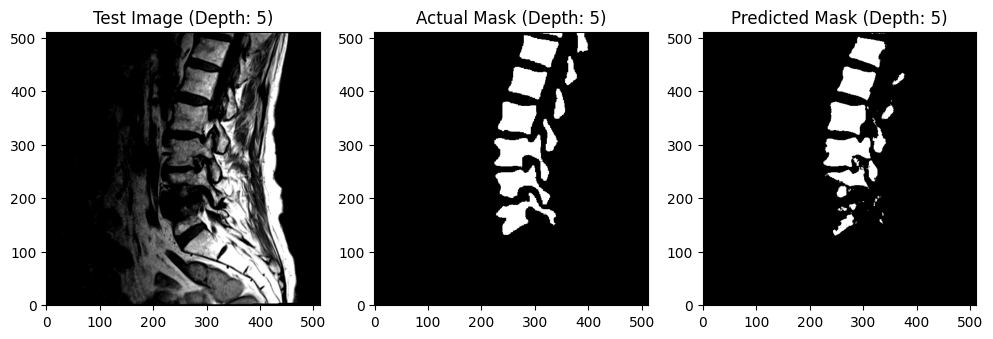

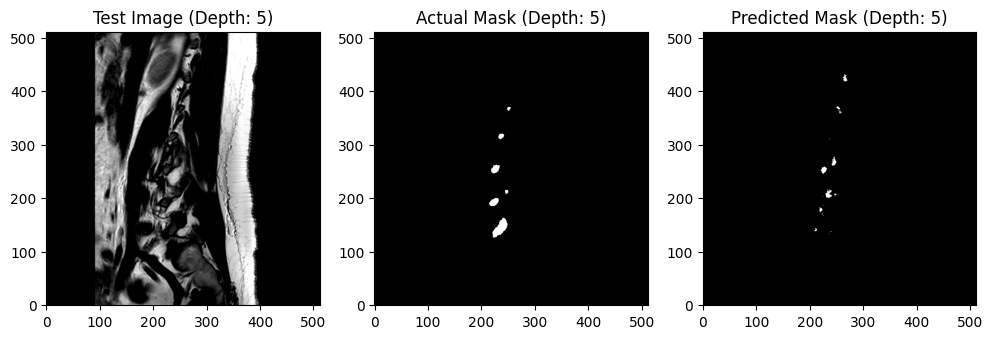

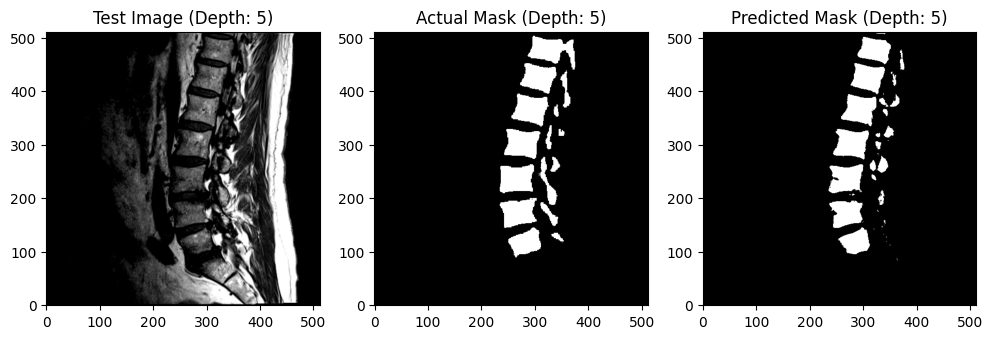

In [46]:
import matplotlib.pyplot as plt

start_idx, end_idx = 22, 25 # Select 3 images to plot

for i in range(start_idx, end_idx): # Select 3 images to plot
    prediction, test_image, test_mask = predict(model, dataset['test'][i], depth_idx)

    fig, ax = plt.subplots(1, 3, figsize=(12, 8))
    ax[0].imshow(test_image.cpu().reshape(512, 512), cmap='gray', origin='lower')
    ax[1].imshow(test_mask.cpu().reshape(512, 512), cmap='gray', vmin=0, vmax=1, origin='lower')
    ax[2].imshow(prediction.cpu().reshape(512, 512), cmap='gray', vmin=0, vmax=1, origin='lower')

    ax[0].set_title(f'Test Image (Depth: {depth_idx+1})')
    ax[1].set_title(f'Actual Mask (Depth: {depth_idx+1})')
    ax[2].set_title(f'Predicted Mask (Depth: {depth_idx+1})')

    plt.show();

Let's also overlay the predicted and actual segmentation masks:



In [47]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['none', 'chartreuse'], name='custom_categorical_cmap')

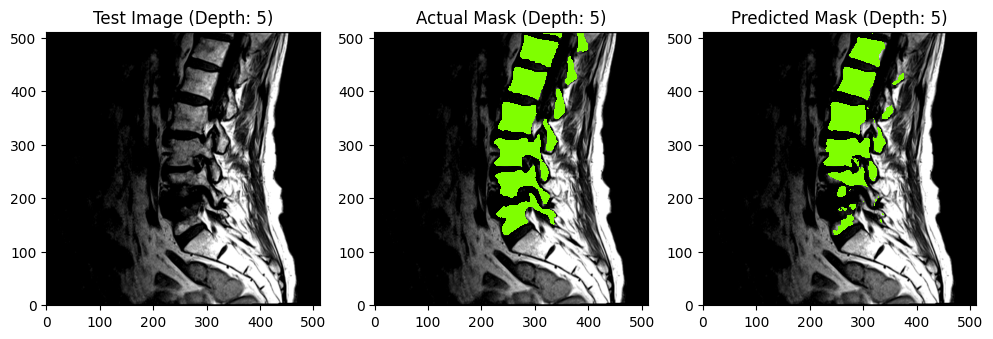

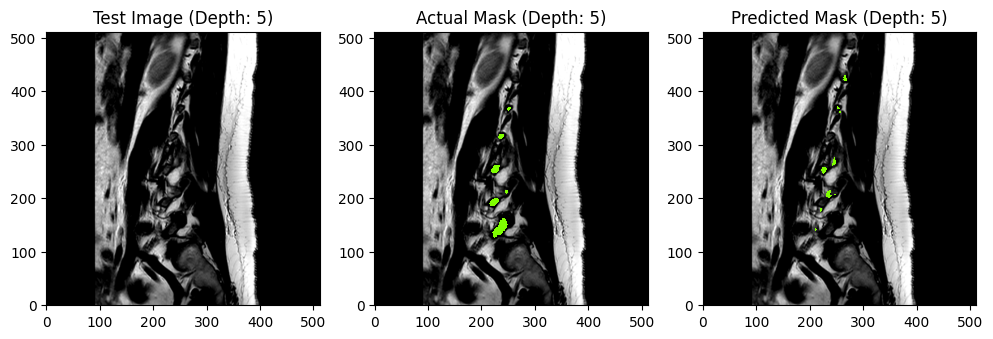

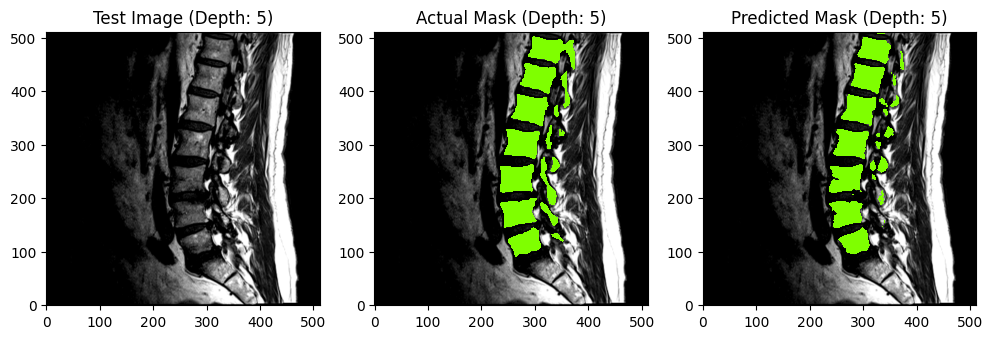

In [48]:
for i in range(start_idx, end_idx):
    prediction, test_image, test_mask = predict(model, dataset['test'][i], depth_idx)

    fig, ax = plt.subplots(1, 3, figsize=(12, 8))
    for j in range(3):
        ax[j].imshow(test_image.cpu().reshape(512, 512), cmap='gray', origin='lower')
    ax[1].imshow(test_mask.cpu().reshape(512, 512), cmap=cmap, vmin=0, vmax=1, origin='lower')
    ax[2].imshow(prediction.cpu().reshape(512, 512), cmap=cmap, vmin=0, vmax=1, origin='lower')

    ax[0].set_title(f'Test Image (Depth: {depth_idx+1})')
    ax[1].set_title(f'Actual Mask (Depth: {depth_idx+1})')
    ax[2].set_title(f'Predicted Mask (Depth: {depth_idx+1})')

    plt.show();

In future extensions of this tutorial, we'll explore ways to segment 3-dimensional images as well as apply various data augmentation techniques to improve model performance.

### Sources



- *van der Graaf, J.W., van Hooff, M.L., Buckens, C.F.M. et al. (2024) Lumbar spine segmentation in MR images: a dataset and a public benchmark. https://doi.org/10.1038/s41597-024-03090-w*

- *Ronneberger, O., Fischer, P., Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. https://doi.org/10.1007/978-3-319-24574-4_28*

- https://github.com/milesial/Pytorch-UNet/tree/master

- https://discuss.pytorch.org/t/understanding-channels-in-binary-segmentation/79966/2